# Análisis y limpieza de datos 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata 
import re
import seaborn as sns

df = pd.read_csv("netflix.csv")



Limpieza general de datos

Filas: 7787  Columnas: 12


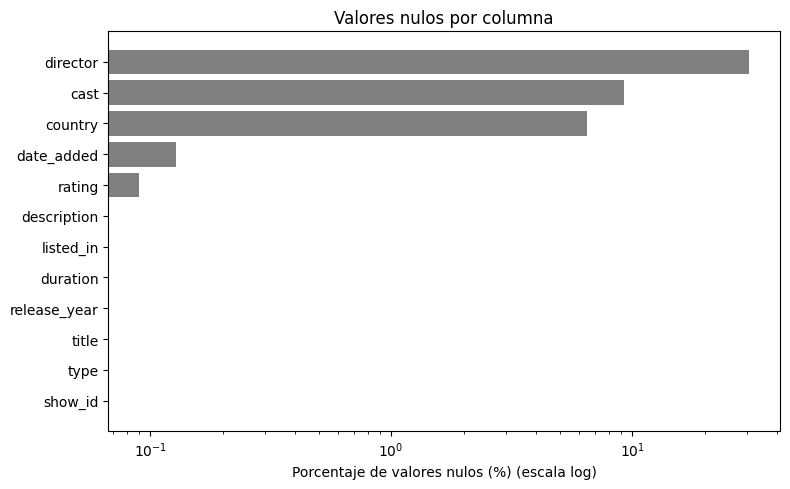

/var/folders/w5/r4237v9175jgsj0grkn8tkhr0000gn/T/ipykernel_73536/362030598.py:40: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_copy['date_added'] = pd.to_datetime(df_copy['date_added'], errors='coerce', dayfirst=False, infer_datetime_format=True)
/var/folders/w5/r4237v9175jgsj0grkn8tkhr0000gn/T/ipykernel_73536/362030598.py:85: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_copy['type'] = df_copy['type'].replace({'Tv Show': 'TV Show', 'Tv show': 'TV Show', 'Tv Show': 'TV Show'})


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration_value,duration_unit,country_list
1485,s1486,Movie,Consequences,Ozan Açıktan,"Nehir Erdoğan, Tardu Flordun, İlker Kaleli, Se...",Turkey,2019-10-25,2014,TV-MA,106 min,"Dramas, International Movies, Thrillers",Secrets bubble to the surface after a sensual ...,106,min,NaN
1486,s1487,Movie,Consequences,Ozan Açıktan,"Nehir Erdoğan, Tardu Flordun, İlker Kaleli, Se...",Turkey,2019-10-25,2014,TV-MA,106 min,"Dramas, International Movies, Thrillers",Secrets bubble to the surface after a sensual ...,106,min,NaN


Antes: 7787 | Después: 7786
Estandarización completada


/var/folders/w5/r4237v9175jgsj0grkn8tkhr0000gn/T/ipykernel_73536/362030598.py:106: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_copy_merged = df_copy.groupby(keys, dropna=False, as_index=False).apply(merge_group).reset_index(drop=True)


In [2]:
# Caracteres invisibles/unicode problemáticos a eliminar
INVISIBLE_CHARS = ["\u200b", "\u200c", "\u200d", "\ufeff"]

def strip_invisible(text):
    if not isinstance(text, str):
        return text
    cleaned = unicodedata.normalize("NFKC", text)

    for ch in INVISIBLE_CHARS:
        cleaned = cleaned.replace(ch, "")

    cleaned = cleaned.strip().strip(".")
    cleaned = re.sub(r'^[-\*\~]+', '', cleaned)
    cleaned = re.sub(r'[-\*\~]+$', '', cleaned)

    return cleaned

# Limpieza de strings
for col in df.columns:
    df[col] = df[col].map(strip_invisible)

print("Filas:", len(df), " Columnas:", len(df.columns))

# Valores nulos por columna
null_pct = (df.isna().mean() * 100).sort_values()

plt.figure(figsize=(8, 5))
plt.barh(null_pct.index, null_pct.values, color='gray')
plt.xscale('log')  

plt.xlabel('Porcentaje de valores nulos (%) (escala log)')
plt.title('Valores nulos por columna')
plt.tight_layout()
plt.show()

df_copy = df.copy()

# Arreglo de fechas 
if 'date_added' in df_copy.columns:
    df_copy['date_added'] = pd.to_datetime(df_copy['date_added'], errors='coerce', dayfirst=False, infer_datetime_format=True)

# Arreglo años de lanzamiento
if 'release_year' in df_copy.columns:
    df_copy['release_year'] = pd.to_numeric(df_copy['release_year'], errors='coerce').astype('Int64')

# Estandarización de unidades de la duración
if 'duration' in df_copy.columns:
    m = df_copy['duration'].str.extract(r'(?P<duration_value>\d+)\s*(?P<duration_unit>\w+)', expand=True)
    df_copy['duration_value'] = pd.to_numeric(m['duration_value'], errors='coerce').astype('Int64')
    df_copy['duration_unit'] = m['duration_unit'].str.lower()

    df_copy['duration_unit'] = df_copy['duration_unit'].replace({
        'mins': 'min', 'minute': 'min', 'minutes': 'min',
        'season': 'season', 'seasons': 'season'
    })

# Campos categóricos comunes
for cat_col in ['type', 'rating']:
    if cat_col in df_copy.columns:
        df_copy[cat_col] = df_copy[cat_col].str.strip()
        if cat_col == 'type':
            df_copy[cat_col] = df_copy[cat_col].str.title()  
        elif cat_col == 'rating':
            df_copy[cat_col] = df_copy[cat_col].str.upper() 
        df_copy[cat_col] = df_copy[cat_col].astype('category')

# Países
if 'country' in df_copy.columns:
    df_copy['country'] = df_copy['country'].str.replace(';', ',', regex=False)
    df_copy['country_list'] = df_copy['country'].str.split(',').map(lambda lst: [x.strip() for x in lst] if isinstance(lst, list) else np.nan)

# Estandarización de rating
if 'rating' in df_copy.columns:
    rating_map = {
        'PG-13': 'PG-13', 'PG13': 'PG-13', 'TVMA': 'TV-MA', 'TV MA': 'TV-MA', 'TV-MA': 'TV-MA',
        'TV14': 'TV-14', 'TV 14': 'TV-14', 'TV-14': 'TV-14',
        'TVPG': 'TV-PG', 'TV PG': 'TV-PG', 'TV-PG': 'TV-PG',
        'TVG': 'TV-G', 'TV G': 'TV-G', 'TV-G': 'TV-G',
        'NR': 'NR', 'NC-17': 'NC-17', 'R': 'R', 'PG': 'PG', 'G': 'G', 'UR': 'UR'
    }
    df_copy['rating'] = df_copy['rating'].replace(rating_map)

# Type: Movie / TV Show
if 'type' in df_copy.columns:
    df_copy['type'] = df_copy['type'].replace({'Tv Show': 'TV Show', 'Tv show': 'TV Show', 'Tv Show': 'TV Show'})

# Trim y NaN en strings vacíos nuevamente por si quedaron casos
for col in df_copy.columns:
    if df_copy[col].dtype == 'object':
        df_copy[col] = df_copy[col].str.strip()
        df_copy[col] = df_copy[col].replace({'': np.nan})

# Duplicados luego de limpieza 
dups = df_copy[df_copy.duplicated(subset=['title', 'director', 'release_year'], keep=False)].sort_values('title')
display(dups.head(20))

keys = ['title', 'director', 'release_year']


def merge_group(g):
    fila = g.iloc[0].copy()
    for _, row in g.iloc[1:].iterrows():
        fila = fila.combine_first(row)
    return fila

df_copy_merged = df_copy.groupby(keys, dropna=False, as_index=False).apply(merge_group).reset_index(drop=True)

print("Antes:", len(df_copy), "| Después:", len(df_copy_merged))


print("Estandarización completada")

df_copy_merged.to_csv("netflix_limpio.csv", index=False, encoding="utf-8")

Limpieza de actores y directores

In [3]:
df = pd.read_csv("netflix_limpio.csv")

In [4]:
import unicodedata as ud
from difflib import SequenceMatcher


def norm_unicode(s):
    s = ud.normalize("NFKC", str(s))
    s = re.sub(r"[\u200B\u200C\u200D\uFEFF\u2060\u00A0]", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def strip_accents_lower_keep_commas(s):
    s = norm_unicode(s)
    s = ud.normalize("NFD", s)
    s = "".join(ch for ch in s if ud.category(ch) != "Mn")
    s = s.lower()
    s = re.sub(r"[^\w\s,\.]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def reorder_if_comma(raw):
    base = strip_accents_lower_keep_commas(raw)
    if "," in base:
        parts = [p.strip() for p in base.split(",") if p.strip()]
        if len(parts) >= 2:
            return f"{parts[1]} {parts[0]}"
    return base

def split_tokens(clean):
    return [t for t in re.split(r"[,\.\s]+", clean) if t]

def surname_tokens(tokens):
    particles = {"de","del","la","las","los","da","das","do","dos","van","von","der","den","le","di"}
    if not tokens: return []
    s_tokens = [tokens[-1]]
    i = len(tokens) - 2
    while i >= 0 and tokens[i] in particles:
        s_tokens.insert(0, tokens[i])
        i -= 1
    return s_tokens

def given_tokens(tokens):
    st = surname_tokens(tokens)
    k = len(tokens) - len(st)
    return tokens[:k]

def initials(tokens):
    excl = {"de","del","la","las","los","da","das","do","dos","van","von","der","den","le","di","jr","sr","ii","iii"}
    return "".join(t[0] for t in tokens if t not in excl and t)

def surname_compact(tokens):
    return "".join(surname_tokens(tokens))

def name_features(s):
    raw = norm_unicode(s)
    clean = reorder_if_comma(raw)
    tokens_ = split_tokens(clean)
    if not any(ch.isalpha() for t in tokens_ for ch in t):
        return {"name_norm":"", "tokens":[], "sname":"", "inits":"", "key": None}
    sname = surname_compact(tokens_)
    inits = initials(tokens_)
    name_norm = " ".join(tokens_)
    key = f"{sname}|{inits}" if sname or inits else None
    return {"name_norm": name_norm, "tokens": tokens_, "sname": sname, "inits": inits, "key": key}

def edit_distance(a, b):
    n, m = len(a), len(b)
    if n == 0: return m
    if m == 0: return n
    dp = list(range(m+1))
    for i in range(1, n+1):
        prev, dp[0] = dp[0], i
        for j in range(1, m+1):
            cur = prev if a[i-1]==b[j-1] else prev+1
            cur = min(cur, dp[j]+1, dp[j-1]+1)
            prev, dp[j] = dp[j], cur
    return dp[m]


def construir_diccionario_correccion(serie):
    exploded = serie.dropna().astype(str).str.split(",").explode().dropna().str.strip()
    exploded = exploded[exploded.str.len() > 0]

    df = pd.DataFrame({"nombre_original": exploded})
    feats = df["nombre_original"].map(name_features)
    df["name_norm"] = feats.map(lambda d: d["name_norm"])
    df["key"] = feats.map(lambda d: d["key"])

    grouped = df.dropna(subset=["key", "name_norm"]).groupby(["key", "name_norm"]).size().rename("count").reset_index()
    variant_dict = grouped.groupby("key").apply(lambda d: dict(zip(d["name_norm"], d["count"]))).to_dict()

    correcciones = {}
    for key, variantes in variant_dict.items():
        if len(variantes) < 2:
            continue
        nombres = list(variantes.keys())
        base = max(variantes.items(), key=lambda x: x[1])[0]
        for alt in nombres:
            if alt == base:
                continue
            if edit_distance(alt, base) <= 2:
                correcciones[alt] = base
    return correcciones

def aplicar_correccion(texto, correcciones):
    if pd.isna(texto): return texto
    partes = [p.strip() for p in str(texto).split(",")]
    corregidos = []
    for p in partes:
        norm = " ".join(split_tokens(reorder_if_comma(p)))
        if norm in correcciones:
            corregidos.append(correcciones[norm].title())
        else:
            corregidos.append(p.strip())
    return ", ".join(corregidos)



df = pd.read_csv("netflix_limpio.csv")

# Corregir cast
correcciones_cast = construir_diccionario_correccion(df["cast"])
df["cast_corr"] = df["cast"].apply(lambda x: aplicar_correccion(x, correcciones_cast))

# Corregir director
correcciones_director = construir_diccionario_correccion(df["director"])
df["director_corr"] = df["director"].apply(lambda x: aplicar_correccion(x, correcciones_director))

# archivo corregido final
df.to_csv("netflix_con_cast_y_director_corregidos.csv", index=False)
print("Archivo guardado como 'netflix_con_cast_y_director_corregidos.csv'")



/var/folders/w5/r4237v9175jgsj0grkn8tkhr0000gn/T/ipykernel_73536/810131717.py:89: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  variant_dict = grouped.groupby("key").apply(lambda d: dict(zip(d["name_norm"], d["count"]))).to_dict()


Archivo guardado como 'netflix_con_cast_y_director_corregidos.csv'


/var/folders/w5/r4237v9175jgsj0grkn8tkhr0000gn/T/ipykernel_73536/810131717.py:89: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  variant_dict = grouped.groupby("key").apply(lambda d: dict(zip(d["name_norm"], d["count"]))).to_dict()


In [5]:
df = pd.read_csv("netflix_con_cast_y_director_corregidos.csv")

# Parte 1
¿Cómo ha cambiado la proporción entre películas y series a lo
largo de los años?

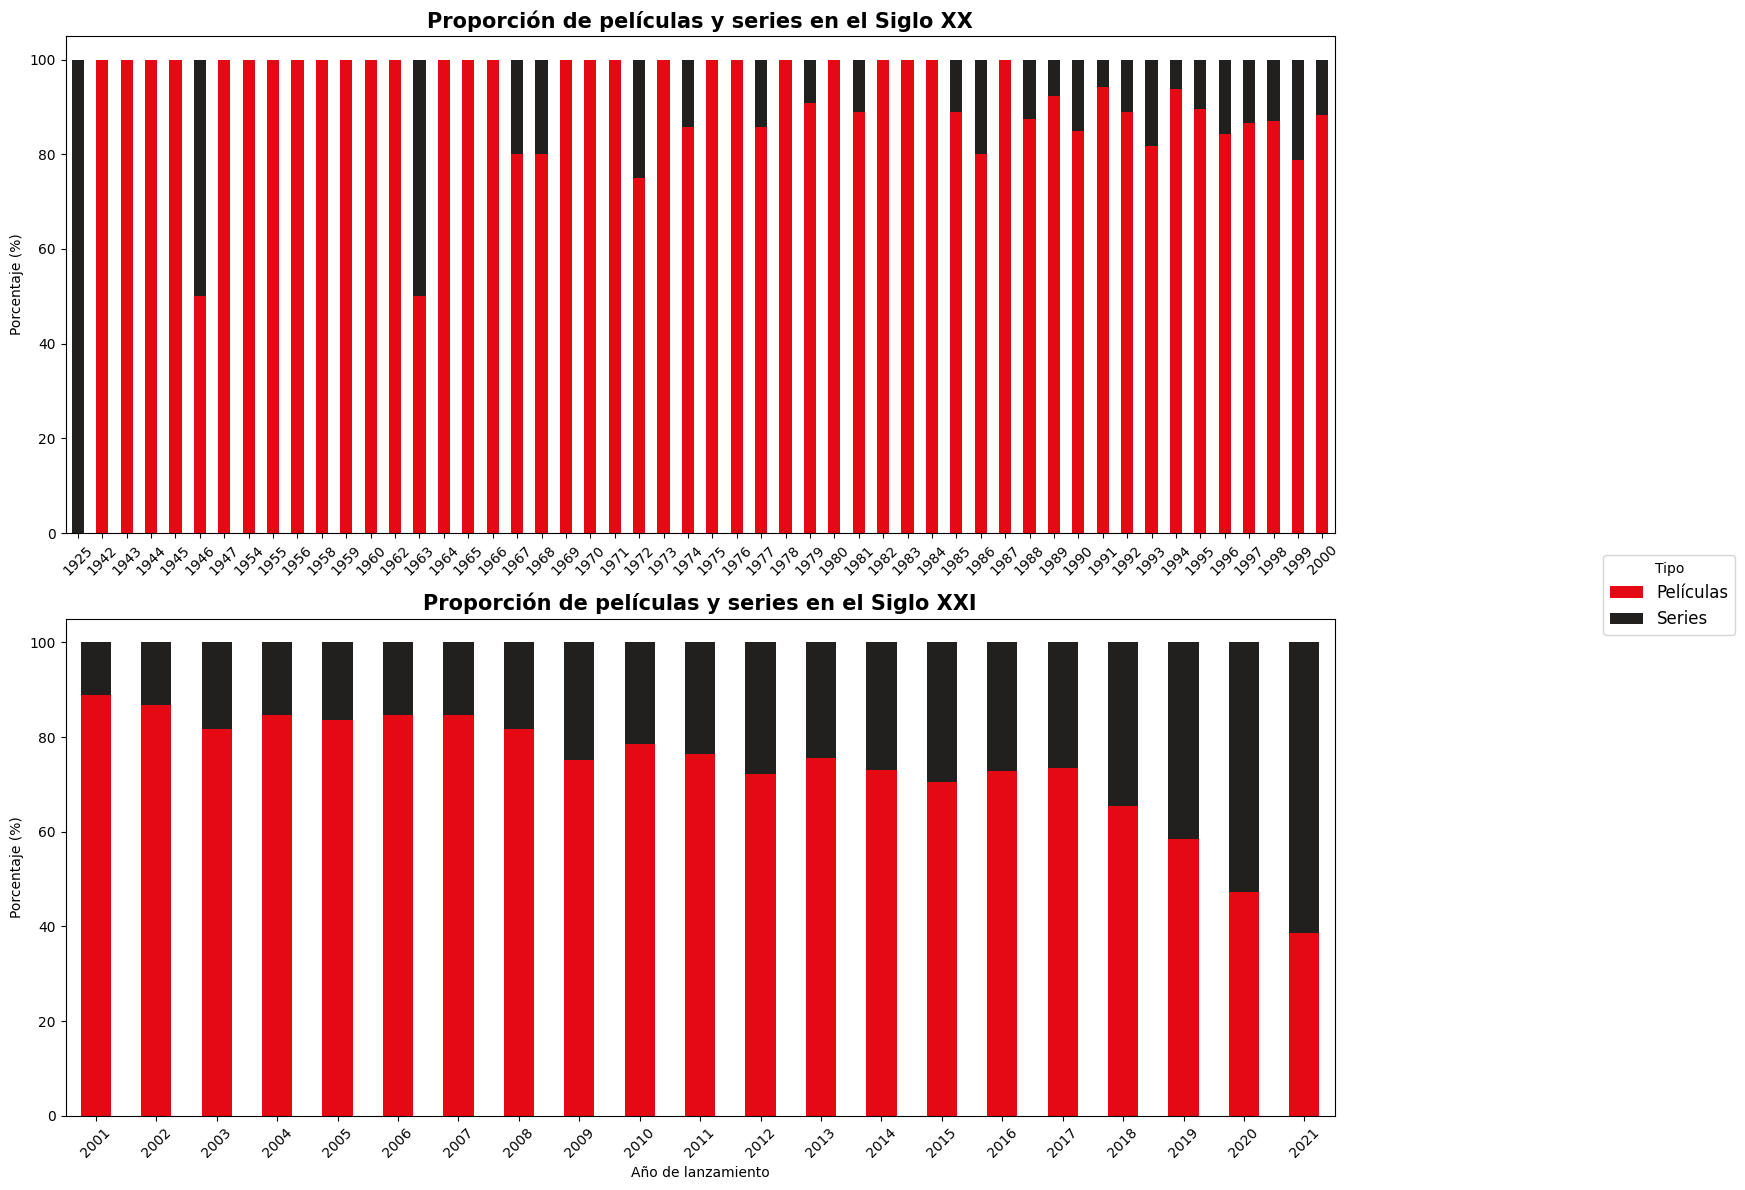

In [6]:
proportion = df.groupby(['release_year', 'type']).size().unstack(fill_value=0)

proportion_percent = proportion.div(proportion.sum(axis=1), axis=0) * 100

colors = ['#e50914', '#221f1f']

proportion_20 = proportion_percent.loc[proportion_percent.index <= 2000]
proportion_21 = proportion_percent.loc[proportion_percent.index > 2000]

fig, axes = plt.subplots(2, 1, figsize=(16,12), sharey=True)

# Siglo XX
proportion_20.plot(kind="bar", stacked=True, color=colors, ax=axes[0])
axes[0].set_title("Proporción de películas y series en el Siglo XX", fontsize=15, fontweight="bold")
axes[0].set_ylabel("Porcentaje (%)")
axes[0].set_xlabel("")
axes[0].tick_params(axis="x", rotation=45)
axes[0].legend_.remove()  

# Siglo XXI
proportion_21.plot(kind="bar", stacked=True, color=colors, ax=axes[1])
axes[1].set_title("Proporción de películas y series en el Siglo XXI", fontsize=15, fontweight="bold")
axes[1].set_ylabel("Porcentaje (%)")
axes[1].set_xlabel("Año de lanzamiento")
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend_.remove()  

fig.legend(title="Tipo", labels=["Películas", "Series"], loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)

plt.tight_layout(rect=[0,0,0.85,1])
plt.show()

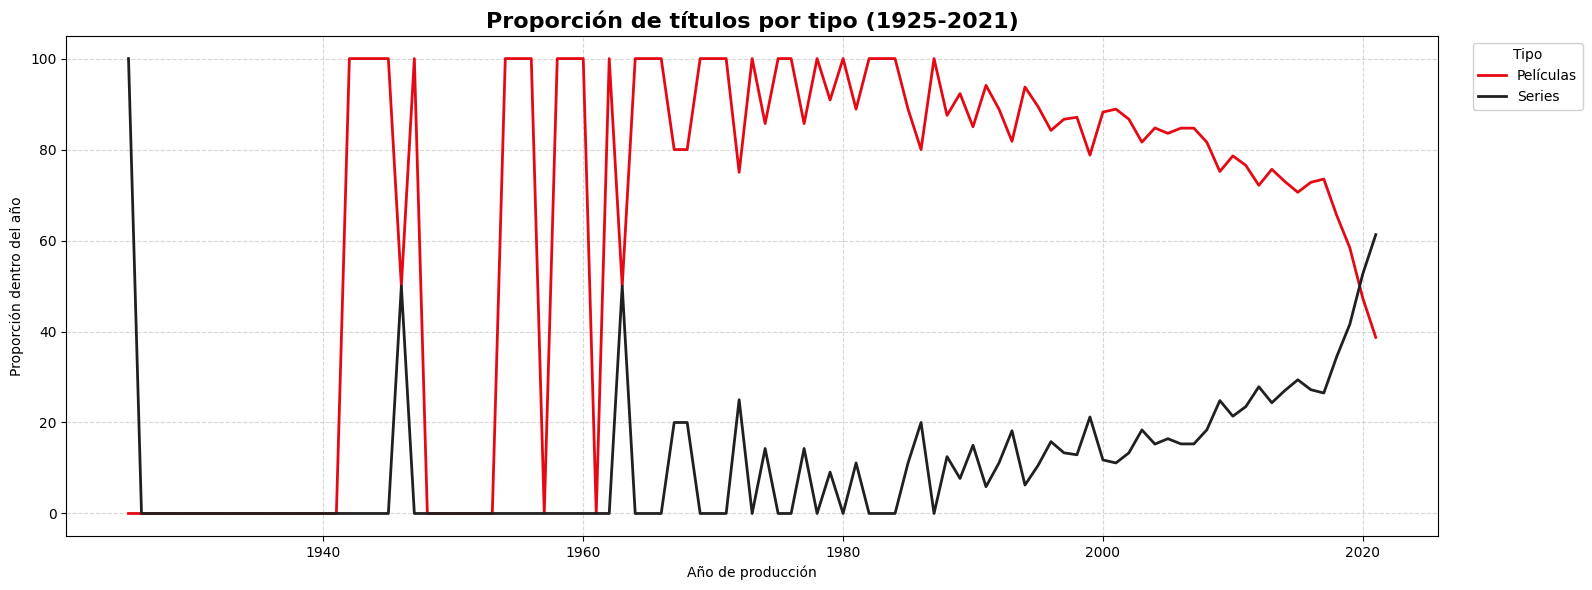

In [21]:
proportion = df.groupby(['release_year', 'type']).size().unstack(fill_value=0)
proportion_percent = proportion.div(proportion.sum(axis=1), axis=0) * 100

full_range = pd.RangeIndex(1925, 2022)  
proportion_percent = proportion_percent.reindex(full_range, fill_value=0)

fig, ax = plt.subplots(figsize=(16,6))

proportion_percent['Movie'].plot(ax=ax, color='#e50914', linewidth=2, label="Películas")
proportion_percent['TV Show'].plot(ax=ax, color='#221f1f', linewidth=2, label="Series")

ax.set_title("Proporción de títulos por tipo (1925-2021)", fontsize=16, fontweight="bold")
ax.set_ylabel("Proporción dentro del año")
ax.set_xlabel("Año de producción")
ax.grid(True, linestyle="--", alpha=0.5)

ax.legend(
    title="Tipo", 
    bbox_to_anchor=(1.02, 1),  
    loc="upper left",
    frameon=True,
    framealpha=0.9
)

plt.tight_layout()
plt.show()


# Parte 2
¿Cómo evolucionó la cantidad de estrenos a lo largo del tiempo
para cada tipo de contenido?

<Figure size 1400x600 with 0 Axes>

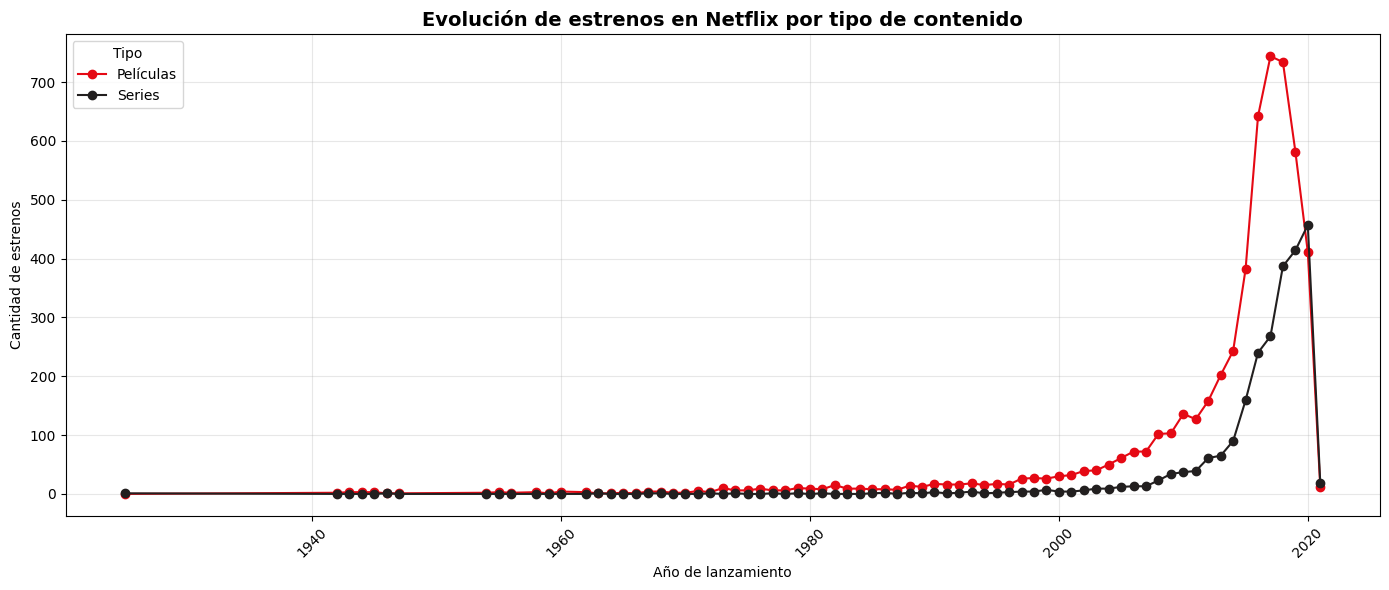

In [26]:
releases = df.groupby(['release_year', 'type']).size().unstack(fill_value=0)

colors = ['#e50914', '#221f1f']  

plt.figure(figsize=(14,6))
releases.plot(kind="line", marker="o", color=colors, figsize=(14,6))

plt.title("Evolución de estrenos en Netflix por tipo de contenido", fontsize=14, fontweight="bold")
plt.ylabel("Cantidad de estrenos")
plt.xlabel("Año de lanzamiento")

plt.legend(title="Tipo", labels=["Películas", "Series"], loc="upper left")

plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Parte 3
¿Cuáles son los países con más producciones? ¿Se destacan
más por películas o series?

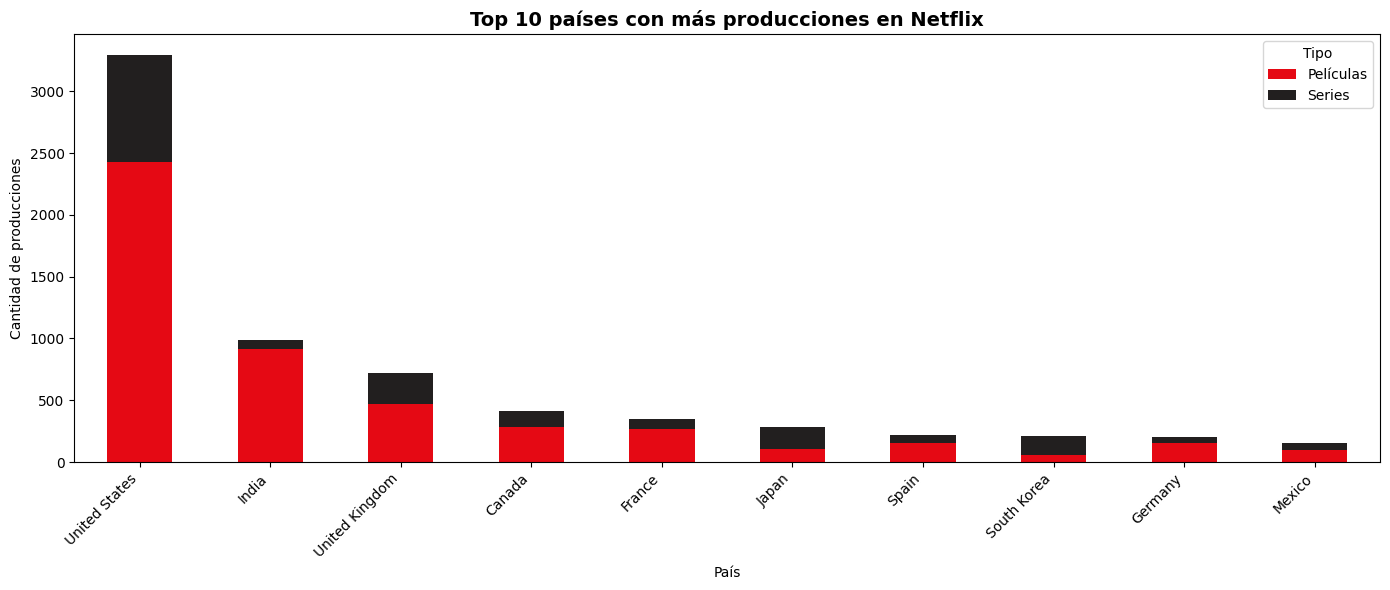

In [9]:
df['country_split'] = df['country'].str.split(", ")
df_explode = df.explode('country_split')

country_counts = df_explode.groupby(['country_split', 'type']).size().unstack(fill_value=0)

top_countries = country_counts.sum(axis=1).sort_values(ascending=False).head(10)
top_countries_data = country_counts.loc[top_countries.index]

colors = ['#e50914', '#221f1f']

top_countries_data.plot(kind="bar", stacked=True, figsize=(14,6), color=colors)

plt.title("Top 10 países con más producciones en Netflix", fontsize=14, fontweight="bold")
plt.ylabel("Cantidad de producciones")
plt.xlabel("País")

plt.legend(title="Tipo", labels=["Películas", "Series"], loc="upper right")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Parte 4
¿Qué tipo de contenido es más común para cada rating?

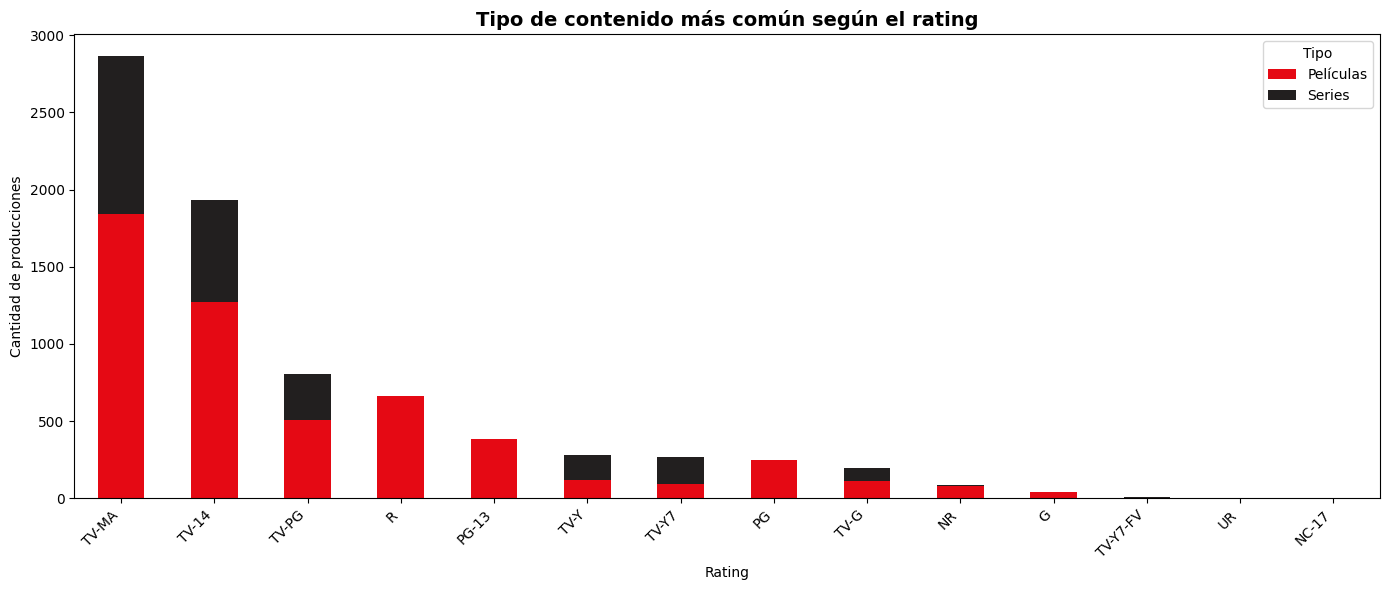

In [10]:
rating_counts = df.groupby(['rating', 'type']).size().unstack(fill_value=0)

rating_counts = rating_counts.loc[rating_counts.sum(axis=1).sort_values(ascending=False).index]

colors = ['#e50914', '#221f1f']

rating_counts.plot(kind="bar", stacked=True, figsize=(14,6), color=colors)

plt.title("Tipo de contenido más común según el rating", fontsize=14, fontweight="bold")
plt.ylabel("Cantidad de producciones")
plt.xlabel("Rating")

plt.legend(title="Tipo", labels=["Películas", "Series"], loc="upper right")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

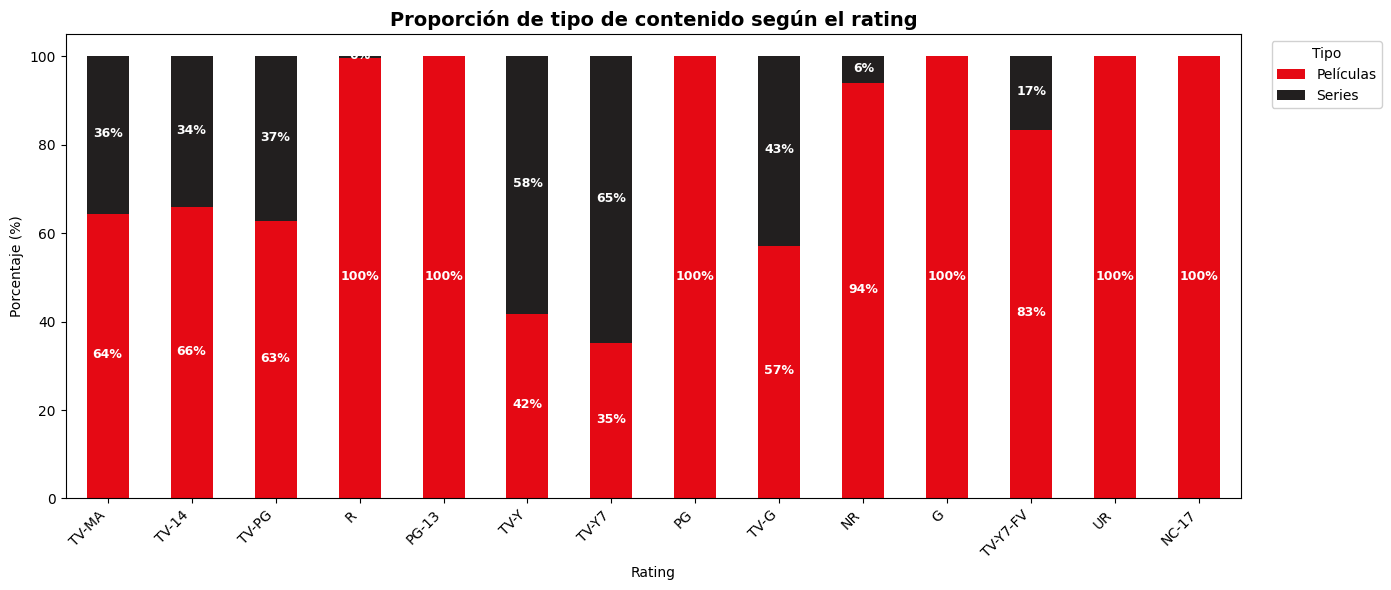

In [30]:
rating_counts = df.groupby(['rating', 'type']).size().unstack(fill_value=0)

rating_counts = rating_counts.loc[rating_counts.sum(axis=1).sort_values(ascending=False).index]

rating_percent = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100

colors = ['#e50914', '#221f1f']

ax = rating_percent.plot(kind="bar", stacked=True, figsize=(14,6), color=colors)

plt.title("Proporción de tipo de contenido según el rating", fontsize=14, fontweight="bold")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Rating")
plt.xticks(rotation=45, ha="right")

ax.legend(
    title="Tipo",
    labels=["Películas", "Series"],
    bbox_to_anchor=(1.02, 1), loc="upper left",
    frameon=True, framealpha=0.9
)

for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f"{v:.0f}%" if v > 0 else "" for v in container.datavalues],
        label_type="center",
        color="white",
        fontsize=9,
        fontweight="bold",
        padding=1
    )

plt.tight_layout()
plt.show()


# Parte 5
¿Qué países producen más contenido para audiencias adultas e
infantiles? ¿Se les ocurre otra separación además de estas dos?

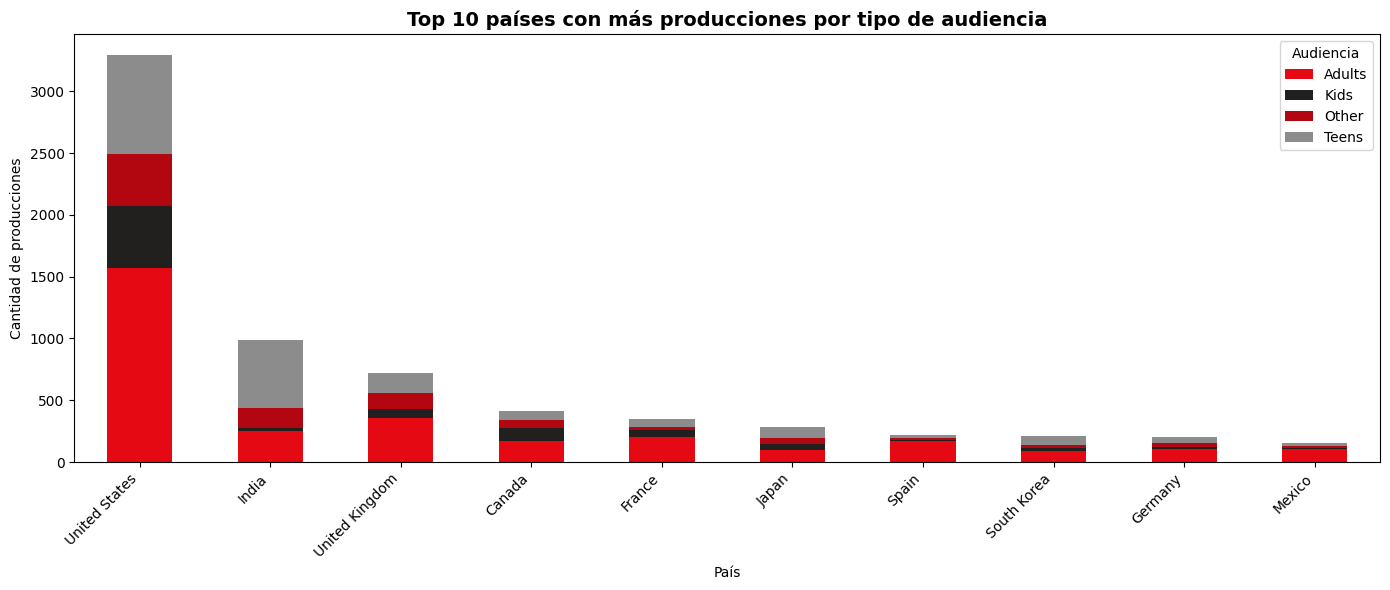

In [11]:
audience_map = {
    "Kids": ["TV-Y", "TV-Y7", "G", "PG"],
    "Teens": ["PG-13", "TV-14"],
    "Adults": ["R", "NC-17", "TV-MA"]
}

def classify_audience(rating):
    for key, values in audience_map.items():
        if rating in values:
            return key
    return "Other"

df["audience"] = df["rating"].apply(classify_audience)

df["country_split"] = df["country"].str.split(", ")
df_explode = df.explode("country_split")

audience_country = df_explode.groupby(["country_split", "audience"]).size().unstack(fill_value=0)

top_countries = audience_country.sum(axis=1).sort_values(ascending=False).head(10)
top_audience_data = audience_country.loc[top_countries.index]

colors = ['#e50914', '#221f1f', '#b20710', '#8c8c8c']  # rojo Netflix, negro y bordo y agregamos un gris que no etsaba en la gama de colores porque no se visualisaba en blanco

top_audience_data.plot(kind="bar", stacked=True, figsize=(14,6), color=colors)

plt.title("Top 10 países con más producciones por tipo de audiencia", fontsize=14, fontweight="bold")
plt.ylabel("Cantidad de producciones")
plt.xlabel("País")

plt.legend(title="Audiencia")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

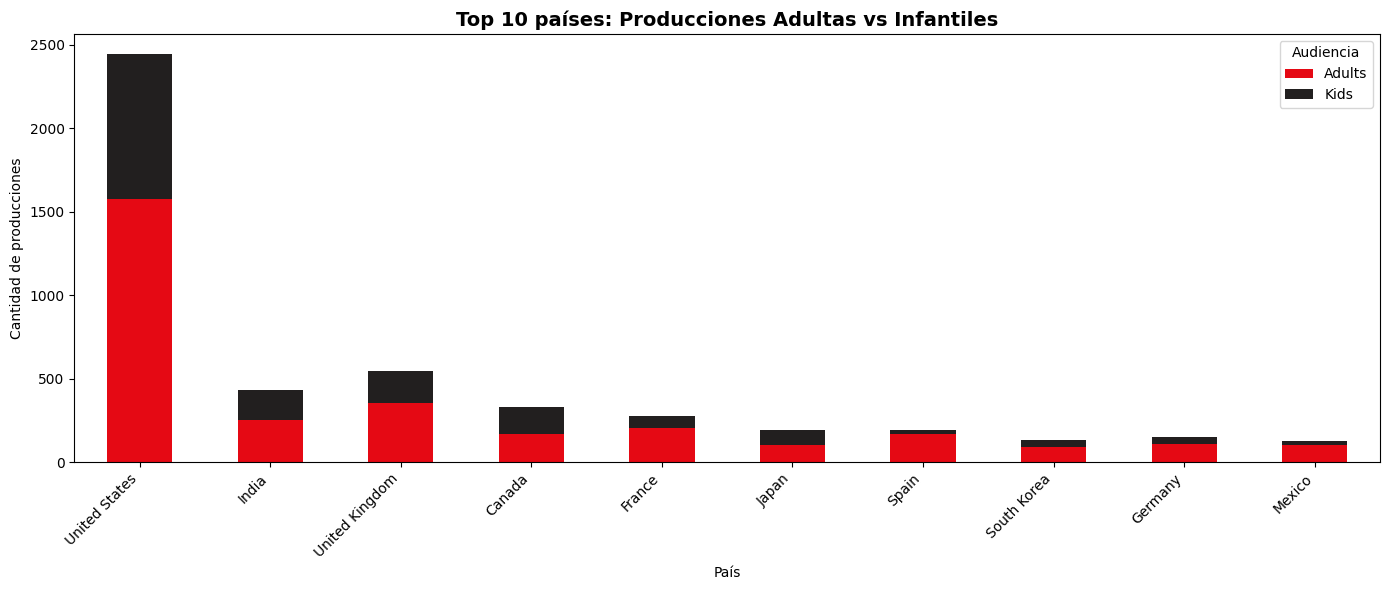

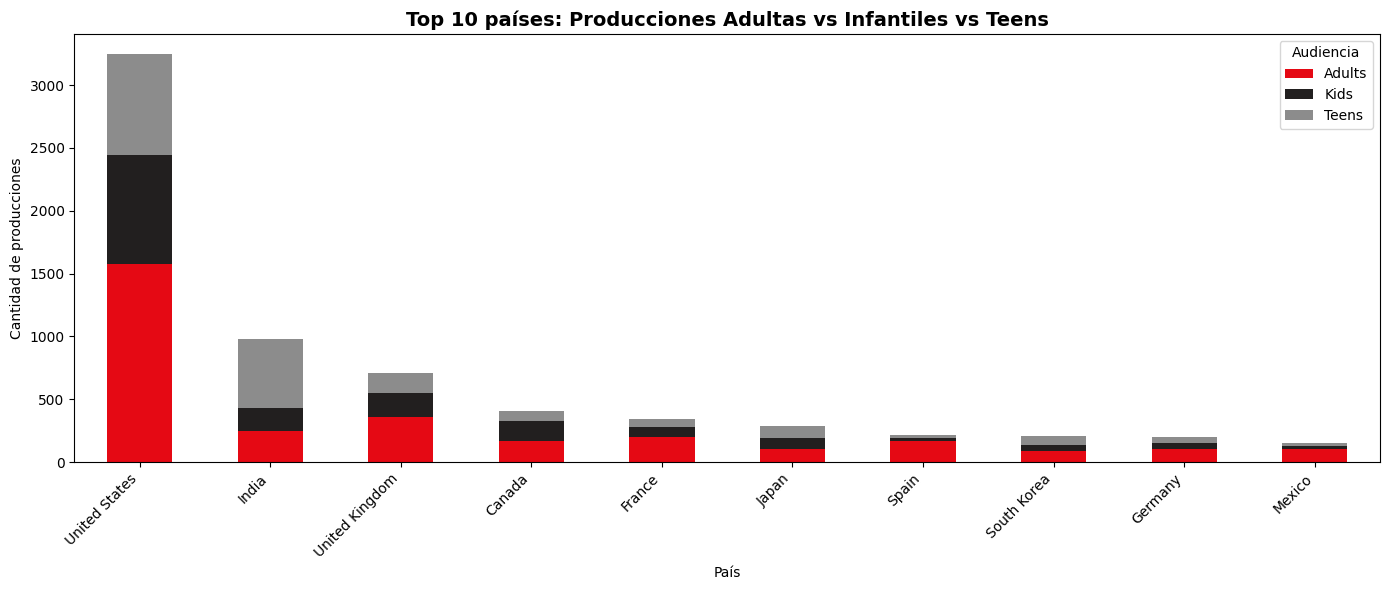

In [31]:
audience_map = {
    "Kids": ["TV-Y", "TV-Y7", "G", "PG", "TV-G", "TV-PG"],
    "Teens": ["PG-13", "TV-14"],
    "Adults": ["R", "NC-17", "TV-MA"],
    "Other": ["NR", "UR"]
}

def classify_audience(rating):
    for key, values in audience_map.items():
        if rating in values:
            return key
    return "Other"

df["audience"] = df["rating"].apply(classify_audience)

df["country_split"] = df["country"].str.split(", ")
df_explode = df.explode("country_split")

audience_country = df_explode.groupby(["country_split", "audience"]).size().unstack(fill_value=0)

top_countries = audience_country.sum(axis=1).sort_values(ascending=False).head(10)
top_audience_data = audience_country.loc[top_countries.index]

# adultos vs infantiles 
adult_kid = top_audience_data[["Adults", "Kids"]]

ax1 = adult_kid.plot(
    kind="bar", stacked=True, figsize=(14,6),
    color=["#e50914", "#221f1f"]
)
ax1.set_title("Top 10 países: Producciones Adultas vs Infantiles", fontsize=14, fontweight="bold")
ax1.set_ylabel("Cantidad de producciones")
ax1.set_xlabel("País")
ax1.legend(title="Audiencia")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# adultos vs infantiles vs teens 
adult_kid_teens = top_audience_data[["Adults", "Kids", "Teens"]]

ax2 = adult_kid_teens.plot(
    kind="bar", stacked=True, figsize=(14,6),
    color=["#e50914", "#221f1f", "#8c8c8c"]
)
ax2.set_title("Top 10 países: Producciones Adultas vs Infantiles vs Teens", fontsize=14, fontweight="bold")
ax2.set_ylabel("Cantidad de producciones")
ax2.set_xlabel("País")
ax2.legend(title="Audiencia")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Parte 6
¿Se identifica alguna estacionalidad en los estrenos según la
categoría (listed in)? Qué meses concentran más lanzamientos?

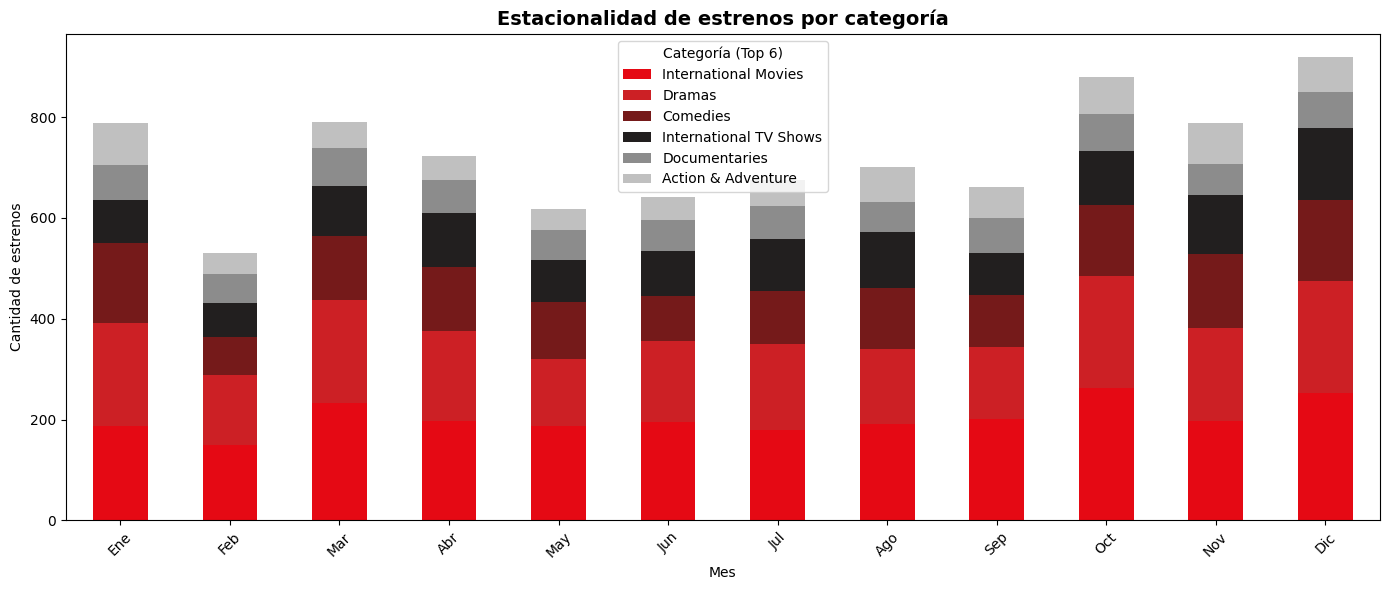

In [12]:
df['month_added'] = pd.to_datetime(df['date_added'], errors="coerce").dt.month

df['listed_split'] = df['listed_in'].str.split(", ")
df_explode = df.explode('listed_split')

monthly_releases = df_explode.groupby(['month_added', 'listed_split']).size().unstack(fill_value=0)

monthly_releases = monthly_releases.sort_index()

colors = ["#e50914", "#cc2025", "#751a1a", "#221f1f", "#8c8c8c", "#c0c0c0"]


top_categories = monthly_releases.sum().sort_values(ascending=False).head(6).index
monthly_top = monthly_releases[top_categories]

monthly_top.plot(kind="bar", stacked=True, figsize=(14,6), color=colors)

plt.title("Estacionalidad de estrenos por categoría", fontsize=14, fontweight="bold")
plt.ylabel("Cantidad de estrenos")
plt.xlabel("Mes")
plt.xticks(range(12), 
           ["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"], 
           rotation=45)

plt.legend(title="Categoría (Top 6)")
plt.tight_layout()
plt.show()

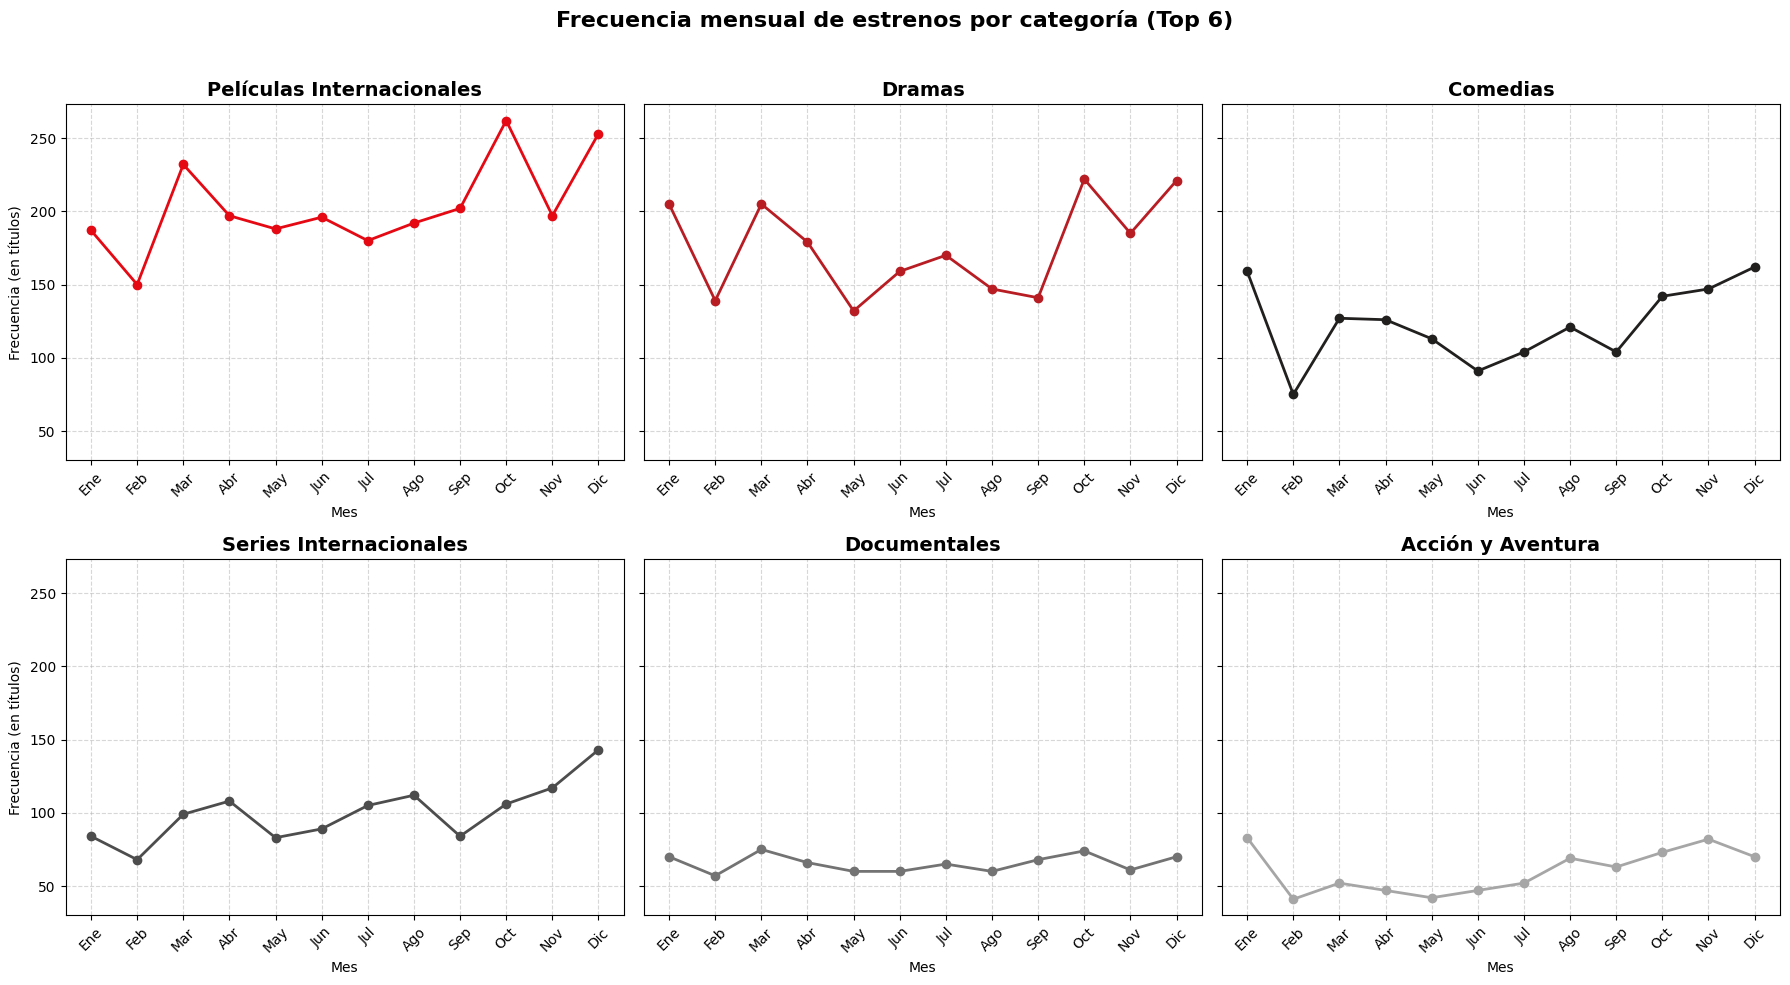

In [ ]:
top_categories = monthly_releases.sum().sort_values(ascending=False).head(6).index
monthly_top = monthly_releases[top_categories]

titles_map = {
    "International Movies": "Películas Internacionales",
    "Dramas": "Dramas",
    "Comedies": "Comedias",
    "International TV Shows": "Series Internacionales",
    "Documentaries": "Documentales",
    "Action & Adventure": "Acción y Aventura"
}

color = "#e50914" 

fig, axes = plt.subplots(2, 3, figsize=(18,10), sharey=True, facecolor="white")

for ax, col in zip(axes.flatten(), top_categories):
    monthly_top[col].plot(
        kind="line", marker="o", color=color, linewidth=2, ax=ax
    )
    
    ax.fill_between(monthly_top.index, monthly_top[col], color=color, alpha=0.1)
    
    ax.set_title(titles_map.get(col, col), fontsize=14, fontweight="bold")
    ax.set_xlabel("Mes")
    ax.set_ylabel("Frecuencia (en títulos)")
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(
        ["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"],
        rotation=45
    )
    ax.grid(True, linestyle="--", alpha=0.5)

fig.suptitle("Frecuencia mensual de estrenos por categoría (Top 6)", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


# Parte 7
¿Qué directores tienen más títulos? ¿Se concentran en algún tipo de contenido o en una audiencia específica?

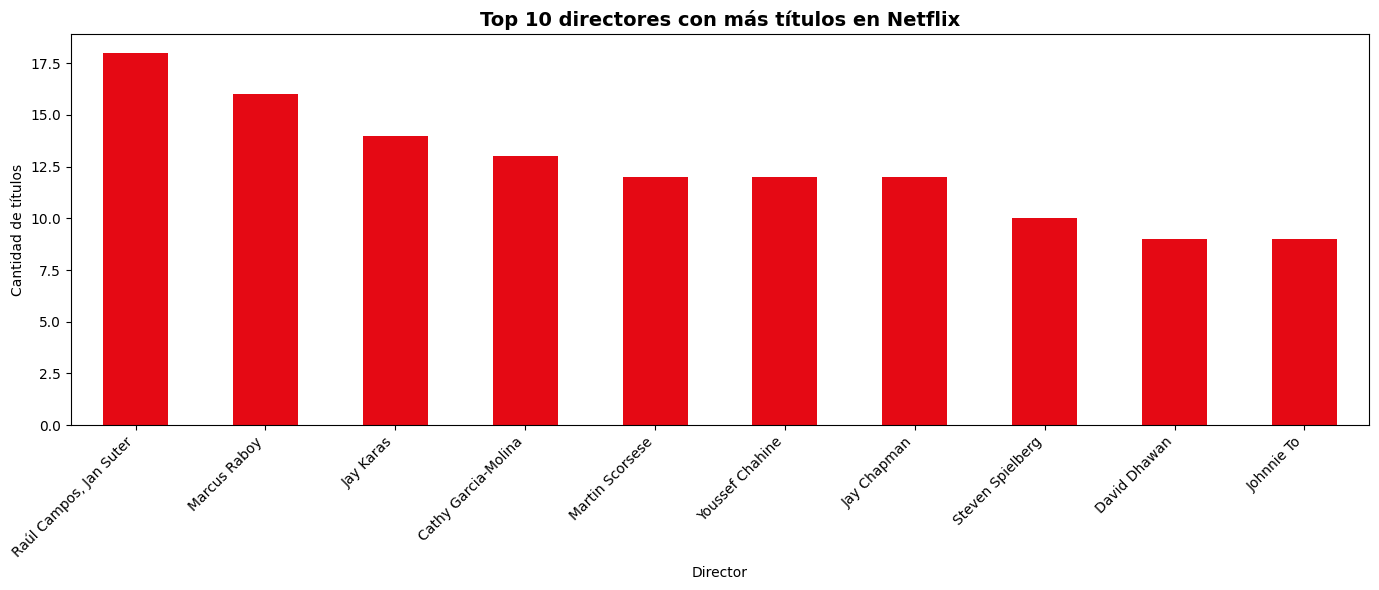

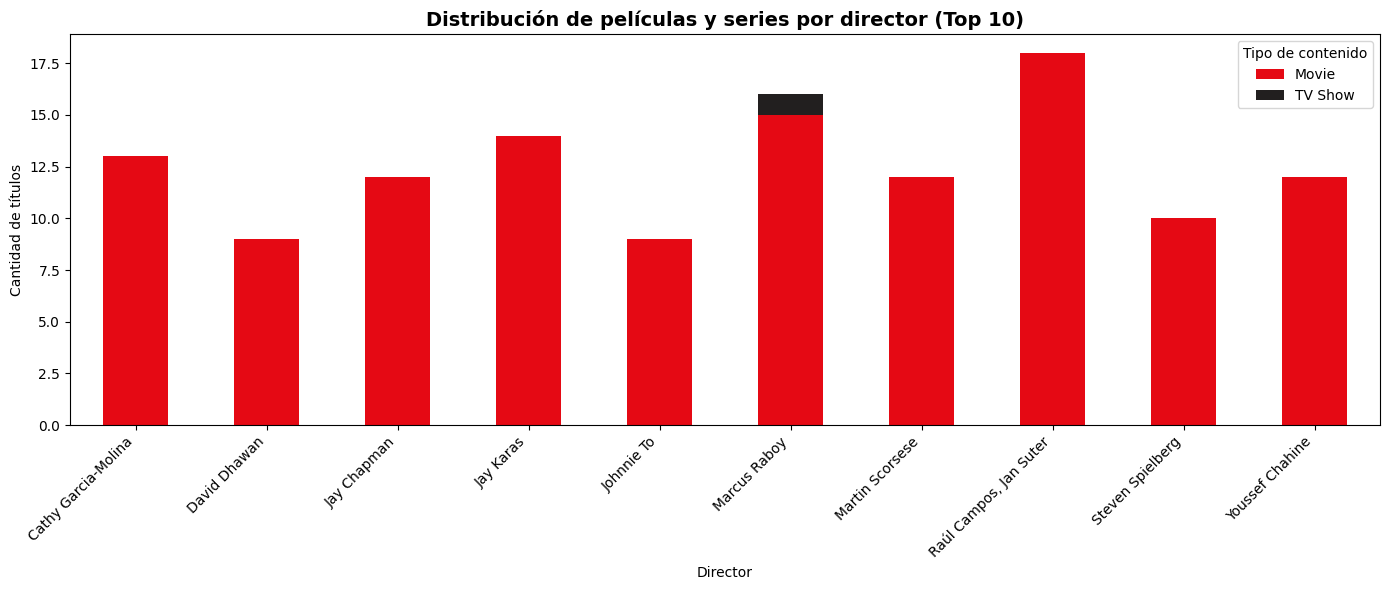

In [13]:

audience_map = {
    "Kids": ["TV-Y", "TV-Y7", "G", "PG"],
    "Teens": ["PG-13", "TV-14"],
    "Adults": ["R", "NC-17", "TV-MA"]
}

def classify_audience(rating):
    for key, values in audience_map.items():
        if rating in values:
            return key
    return "Other"

df["audience"] = df["rating"].apply(classify_audience)

df_directors = df[df["director_corr"] != "Unknown"]

top_directors = df_directors["director_corr"].value_counts().head(10)

df_top_directors = df_directors[df_directors["director_corr"].isin(top_directors.index)]

director_content = df_top_directors.groupby(["director_corr", "type"]).size().unstack(fill_value=0)

colors = ["#e50914", "#b20710", "#8c1c13", "#221f1f", "#444444", "#c0c0c0"]

# Gráfico 1: Top 10 directores por cantidad de títulos
plt.figure(figsize=(14,6))
top_directors.plot(kind="bar", color=colors[0])
plt.title("Top 10 directores con más títulos en Netflix", fontsize=14, fontweight="bold")
plt.ylabel("Cantidad de títulos")
plt.xlabel("Director")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Gráfico 2: Distribución entre películas y series para el top 10 
director_content.plot(kind="bar", stacked=True, figsize=(14,6), color=[colors[0], colors[3]])
plt.title("Distribución de películas y series por director (Top 10)", fontsize=14, fontweight="bold")
plt.ylabel("Cantidad de títulos")
plt.xlabel("Director")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Tipo de contenido")
plt.tight_layout()
plt.show()


# Parte 8
¿Cuáles son los actores más populares?


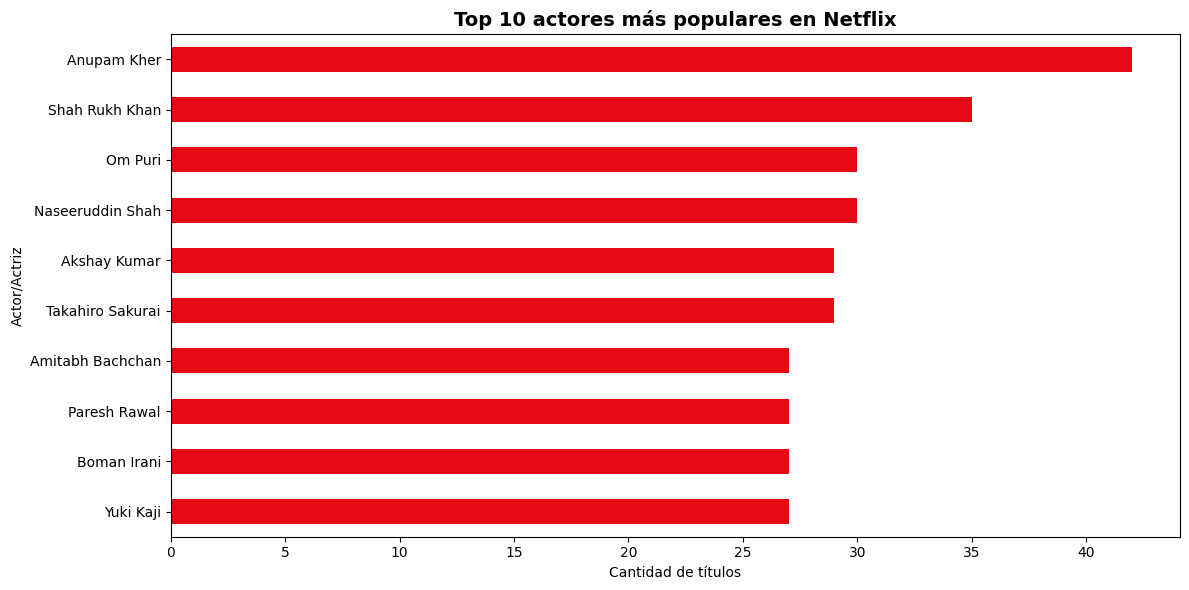

In [14]:
df_actors = df[df["cast_corr"] != "Unknown"].copy()

df_actors["cast_split"] = df_actors["cast_corr"].str.split(", ")
df_explode_actors = df_actors.explode("cast_split")

top_actors = df_explode_actors["cast_split"].value_counts().head(10)

colors = ["#e50914"]

plt.figure(figsize=(12,6))
top_actors.sort_values().plot(kind="barh", color=colors[0])

plt.title("Top 10 actores más populares en Netflix", fontsize=14, fontweight="bold")
plt.xlabel("Cantidad de títulos")
plt.ylabel("Actor/Actriz")

plt.tight_layout()
plt.show()

# Parte 9
¿Cuál es la distribución en duración en series y películas?

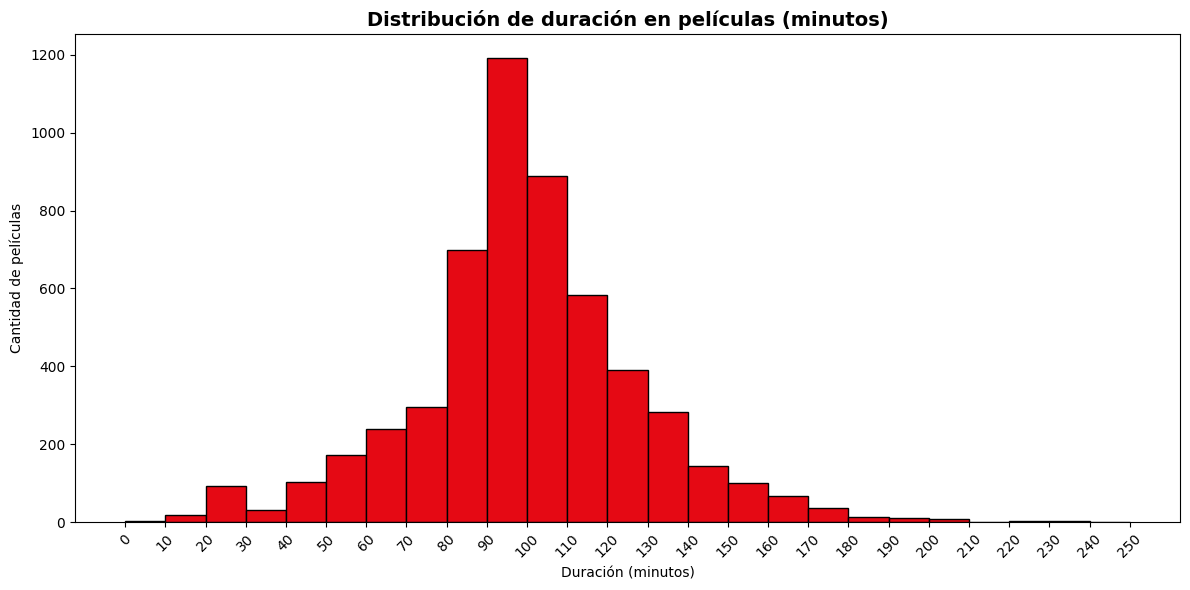

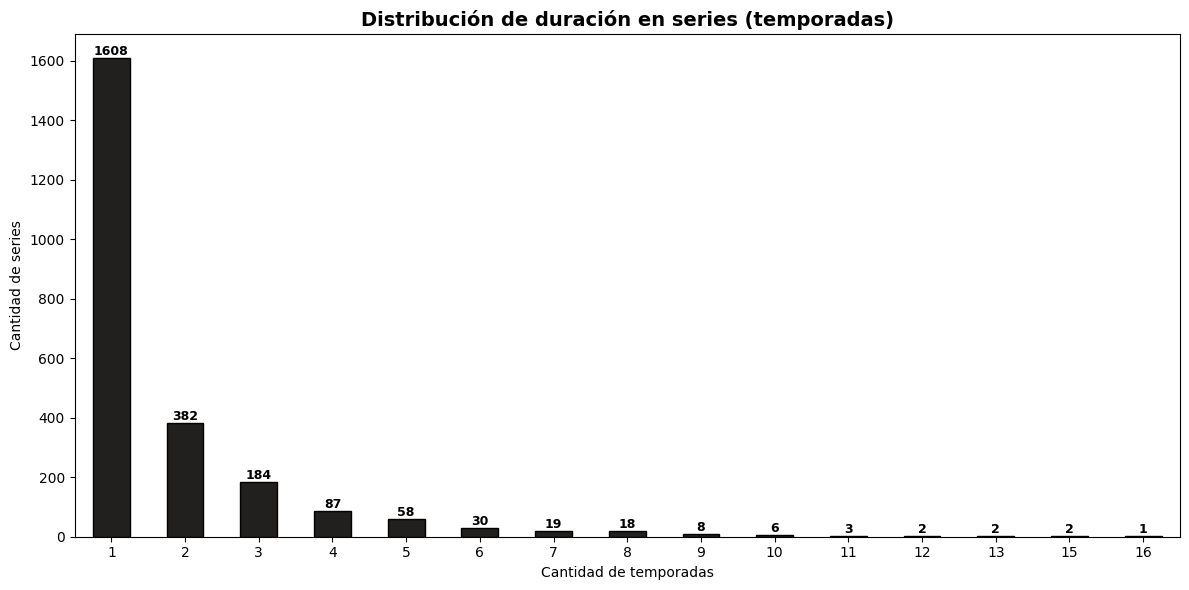

In [15]:
# Películas

movies = df[df["type"] == "Movie"]["duration"].dropna()

movie_minutes = movies.str.extract(r'(\d+)').dropna().astype(int)[0]

plt.figure(figsize=(12,6))
bins = range(0, 251, 10) 
plt.hist(movie_minutes, bins=bins, color="#e50914", edgecolor="black")

plt.title("Distribución de duración en películas (minutos)", fontsize=14, fontweight="bold")
plt.xlabel("Duración (minutos)")
plt.ylabel("Cantidad de películas")
plt.xticks(bins, rotation=45)
plt.tight_layout()
plt.show()

# Series 
series = df[df["type"] == "TV Show"]["duration"].dropna()

season_numbers = series.str.extract(r'(\d+)').dropna().astype(int)[0]
season_counts = season_numbers.value_counts().sort_index()

plt.figure(figsize=(12,6))
ax = season_counts.plot(kind="bar", color="#221f1f", edgecolor="black")

plt.title("Distribución de duración en series (temporadas)", fontsize=14, fontweight="bold")
plt.xlabel("Cantidad de temporadas")
plt.ylabel("Cantidad de series")

for p in ax.patches:
    value = int(p.get_height())
    ax.annotate(str(value),
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9, fontweight="bold")

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Parte 10
¿Hay palabras que se utilicen más que otras en títulos y descripciones?

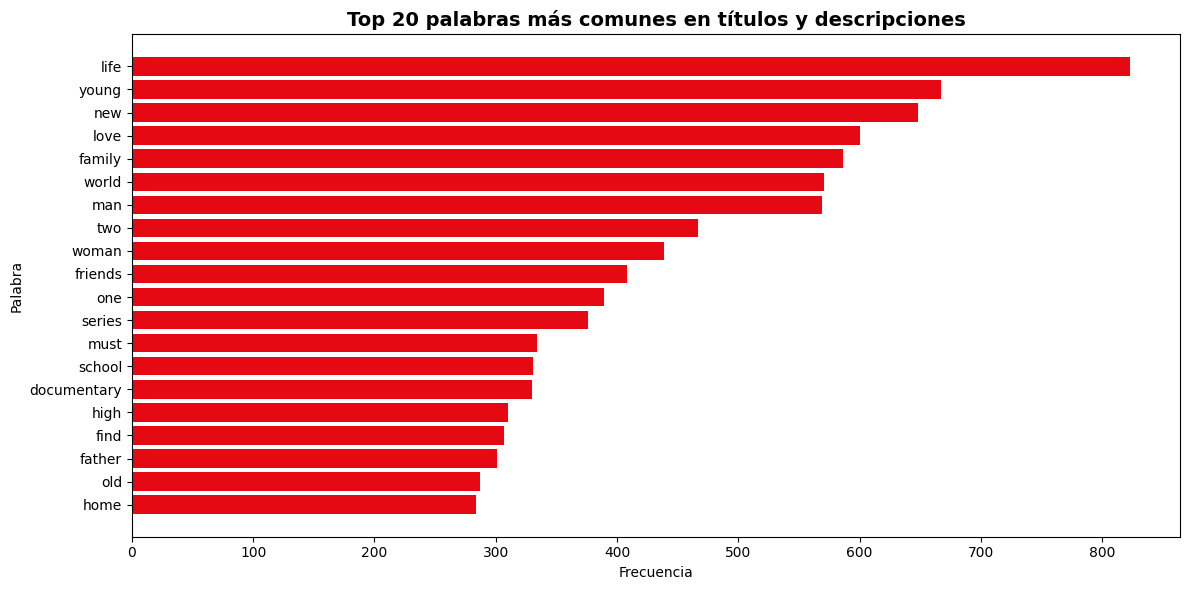

In [16]:
import re
from collections import Counter

# Stop Words arhcivo - carga
with open("stop_words.txt", "r") as f:
    stop_words = set([w.strip() for w in f.readlines()])

text = (df["title"].astype(str) + " " + df["description"].astype(str)).str.lower()

words = []
for line in text:
    tokens = re.findall(r"\b[a-zA-ZáéíóúñüÁÉÍÓÚÑÜ]+\b", line)  
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]  
    words.extend(tokens)

counter = Counter(words)
top_words = counter.most_common(20)

top_df = pd.DataFrame(top_words, columns=["Palabra", "Frecuencia"])

plt.figure(figsize=(12,6))
plt.barh(top_df["Palabra"], top_df["Frecuencia"], color="#e50914")
plt.gca().invert_yaxis()  # la más frecuente arriba
plt.title("Top 20 palabras más comunes en títulos y descripciones", fontsize=14, fontweight="bold")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.tight_layout()
plt.show()